In [7]:
%matplotlib inline

import numpy as np
import scipy as scp
import re
import os
import sys
import pandas as pd
import shutil
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import matplotlib.pyplot as plt
import itertools
from joblib import load, dump

# adding project folder to lib search path
project = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'scripts'))
if project not in sys.path:
    sys.path.append(project)
    
from loader import *
from work_with_files import *
import tree_building
import classificator_k_mer
import data_prep_k_mer
from calculating_metrics import *
import quantitative_analyze

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [37]:
def making_classificator_v_2(feature_matrix, labels, name, n_estimators=350, max_depth=15, bootstrap='True',
                         max_features='sqrt', n_jobs=-1, class_weight='balanced'):
    """
        Making Random Forest classificator and storing it at 'saved_sklean_models' dir
        If you want to change classificator parameters, please see scikit-learn documentation
        Note: class of human proteins is 1, class of others' proteins is 0

    Args:
        feature_matrix: array, array with features needed to train classificator
        labels: array, array with labels connected to feature_matrix to train classificator
        name: str, name for the classificator to save
    Random Forest parameters:
        n_estimators: int, default = 300
        max_depth: int, default = 15
        bootstrap: str, default = 'True'
        max_features: str, default = 'sqrt'
        n_jobs: int, default = -1
    """

    # Making 2 Train-Test split
    train_feature_matrix, test_feature_matrix, \
    train_labels, test_labels = train_test_split(feature_matrix, labels, test_size=0.1, random_state=42)

    # Fitting our classificator
    forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap,
                                    max_features=max_features, n_jobs=n_jobs, class_weight=class_weight)
    forest.fit(train_feature_matrix, train_labels)

    # showing score for user
    y_pred = forest.predict(test_feature_matrix)
    print(classification_report(test_labels, y_pred, labels=[0, 1]))

    # saving classificator in 'saved_sklearn_models' folder
    print(r'Saving classificator in ../saved_sklearn_models/ folder')

    # making dir
    if not os.path.isdir('saved_sklearn_models'):
        os.mkdir('saved_sklearn_models')
        print('saved_sklearn_models directory is created')

    # saving model
    dump(forest, f'saved_sklearn_models/{name}.joblib')

    return

In [4]:
# reading CSVs

feature_matrix, labels = classificator_k_mer.preprocessing_data('data/csv_data_without_trembl/')

#### Classes are unbalanced

In [16]:
labels.count(0)

81599

In [19]:
labels.count(1)

20350

### Class_weight = 'balance'

In [38]:
making_classificator_v_2(feature_matrix, labels, 'weight_balance')

              precision    recall  f1-score   support

           0       0.89      0.98      0.94      8253
           1       0.88      0.50      0.64      1942

    accuracy                           0.89     10195
   macro avg       0.89      0.74      0.79     10195
weighted avg       0.89      0.89      0.88     10195

Saving classificator in ../saved_sklearn_models/ folder


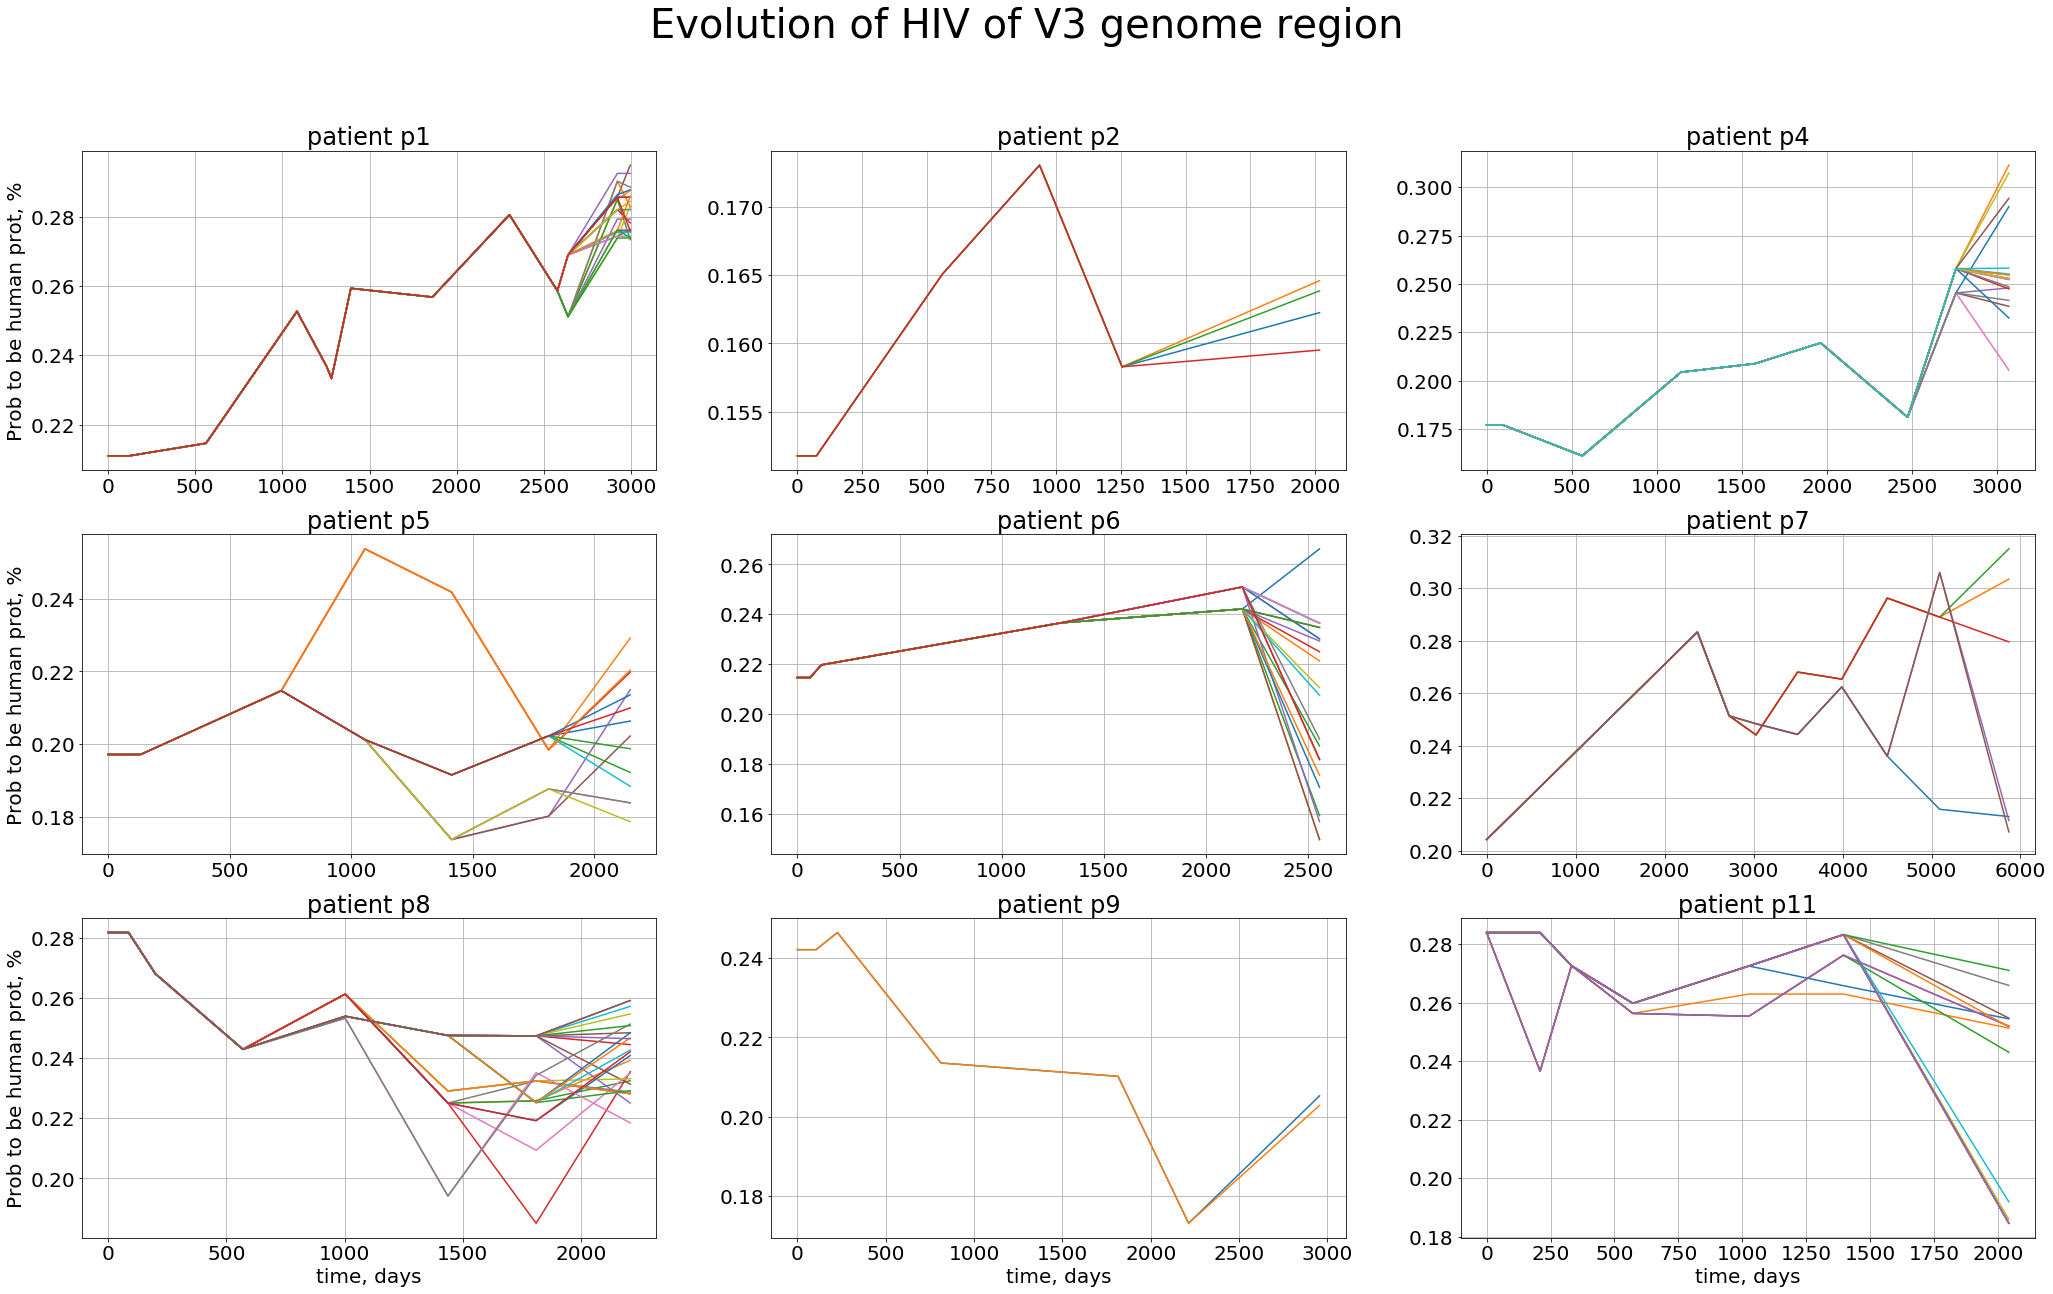

In [39]:
# Using our magic to analyze

quant = quantitative_analyze.Quantitative([f'p{i}' for i in range(1, 12)])

quant.loading_classificator('saved_sklearn_models/weight_balance.joblib')

quant.quantitative_analyzes('V3')

quant.plot_paths()

### Class_weight = 'balance_subsample'

In [40]:
making_classificator_v_2(feature_matrix, labels, 'weight_balance_subsample', class_weight='balanced_subsample')

              precision    recall  f1-score   support

           0       0.89      0.98      0.94      8253
           1       0.88      0.50      0.64      1942

    accuracy                           0.89     10195
   macro avg       0.89      0.74      0.79     10195
weighted avg       0.89      0.89      0.88     10195

Saving classificator in ../saved_sklearn_models/ folder


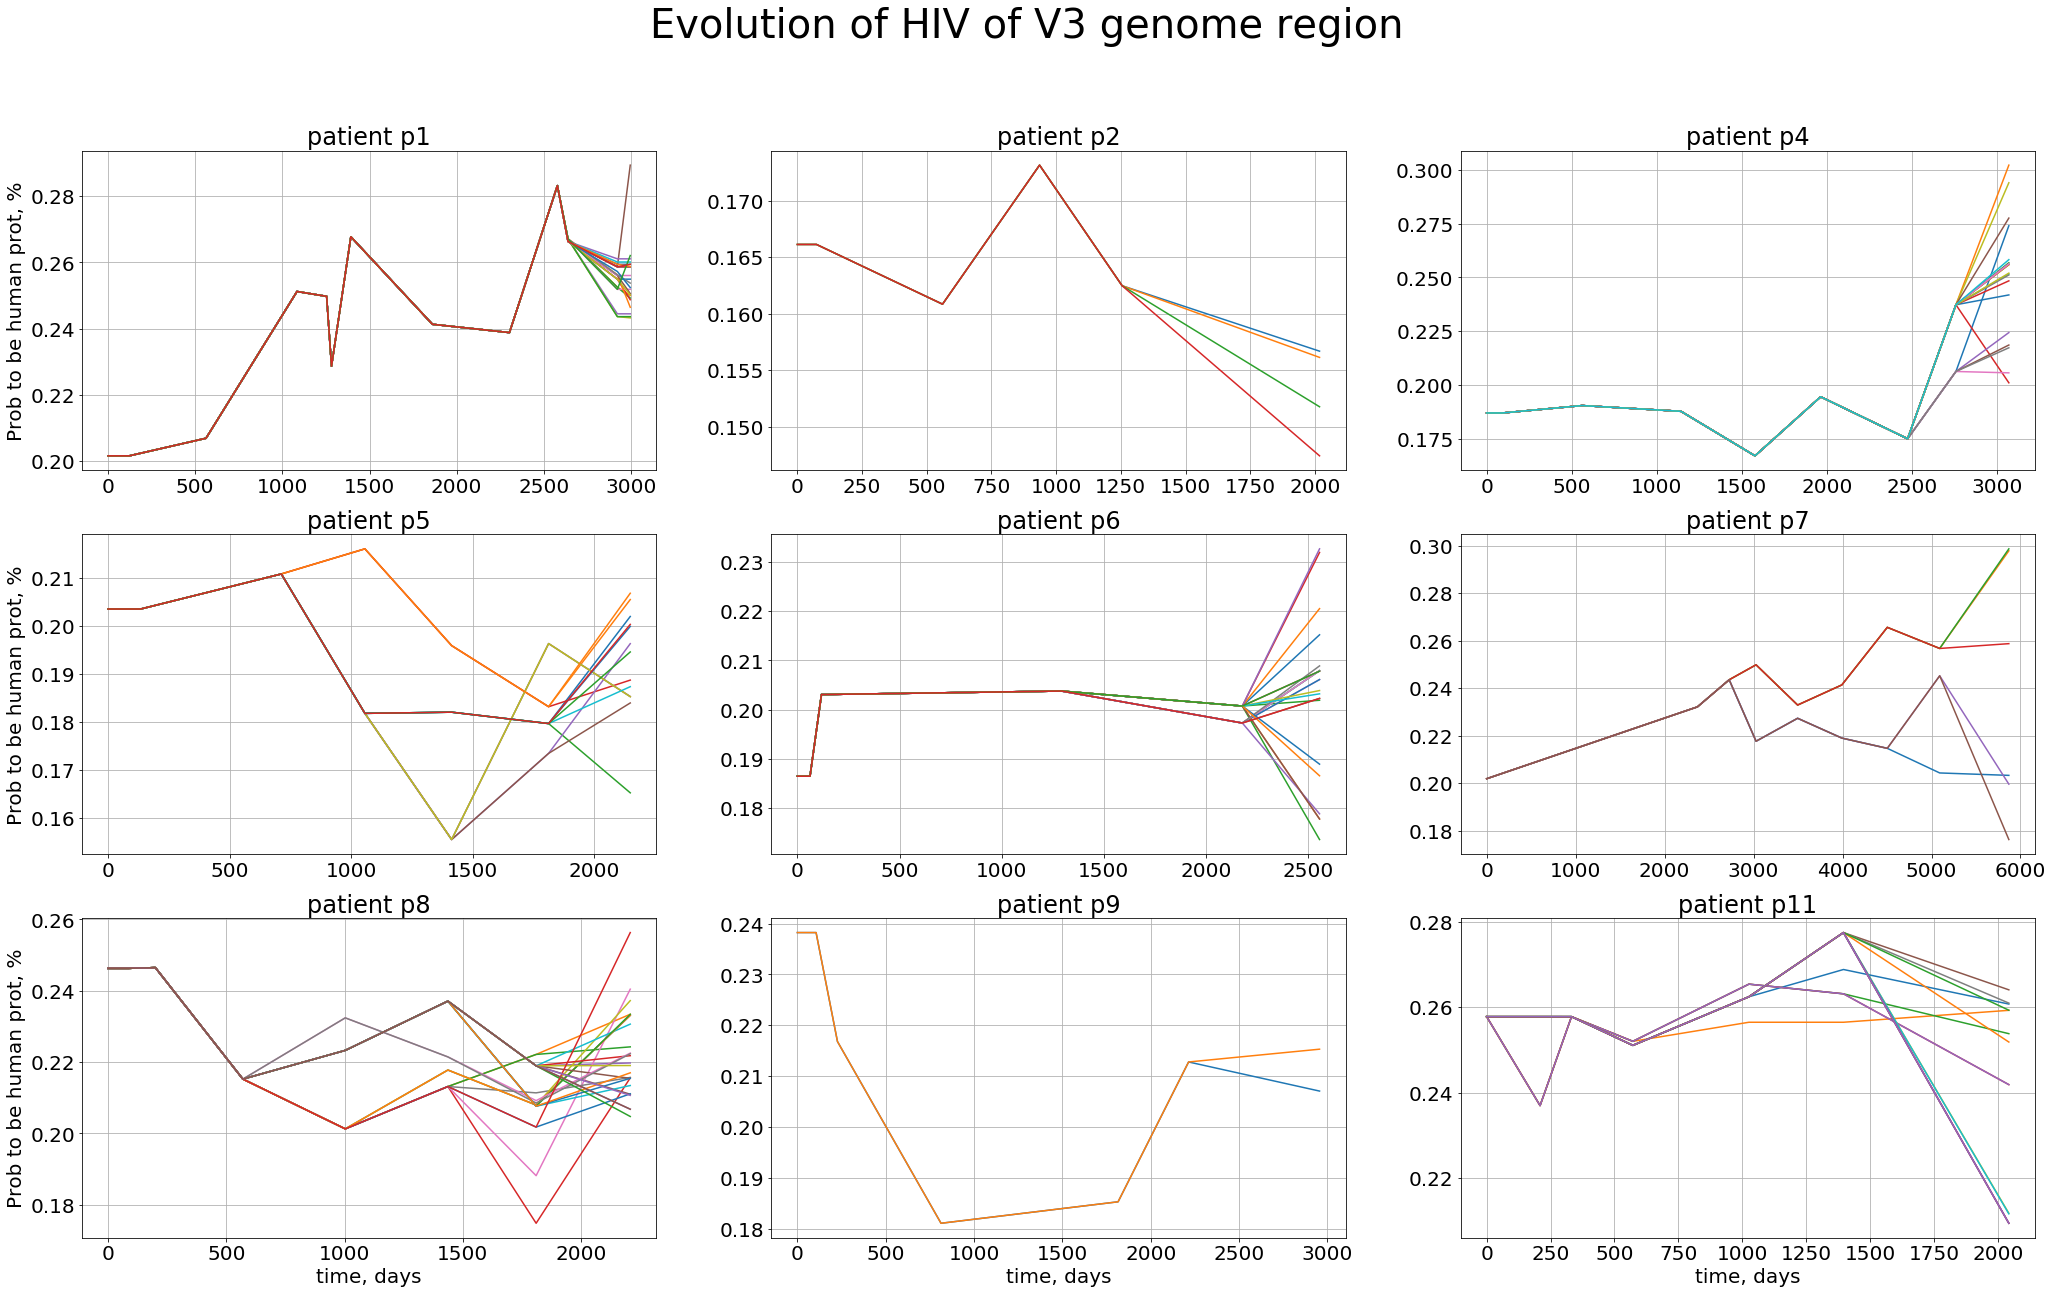

In [41]:
# Using our magic to analyze

quant = quantitative_analyze.Quantitative([f'p{i}' for i in range(1, 12)])

quant.loading_classificator('saved_sklearn_models/weight_balance_subsample.joblib')

quant.quantitative_analyzes('V3')

quant.plot_paths()

### Imblearn

In [42]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [43]:
def imb(feature_matrix, labels, name, n_estimators=300, max_depth=15, bootstrap='True',
                         max_features='sqrt', n_jobs=-1):
    # Making 2 Train-Test split
    train_feature_matrix, test_feature_matrix, \
    train_labels, test_labels = train_test_split(feature_matrix, labels, test_size=0.1, random_state=42)

    # Fitting our classificator
    forest = BalancedRandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap,
                                    max_features=max_features, n_jobs=n_jobs)
    forest.fit(train_feature_matrix, train_labels)

    # showing score for user
    y_pred = forest.predict(test_feature_matrix)
    print(classification_report(test_labels, y_pred, labels=[0, 1]))

    # saving classificator in 'saved_sklearn_models' folder
    print(r'Saving classificator in ../saved_sklearn_models/ folder')

    # making dir
    if not os.path.isdir('saved_sklearn_models'):
        os.mkdir('saved_sklearn_models')
        print('saved_sklearn_models directory is created')

    # saving model
    dump(forest, f'saved_sklearn_models/{name}.joblib')

In [44]:
imb(feature_matrix, labels, 'imblearn')

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      8253
           1       0.58      0.84      0.69      1942

    accuracy                           0.85     10195
   macro avg       0.77      0.85      0.80     10195
weighted avg       0.89      0.85      0.86     10195

Saving classificator in ../saved_sklearn_models/ folder


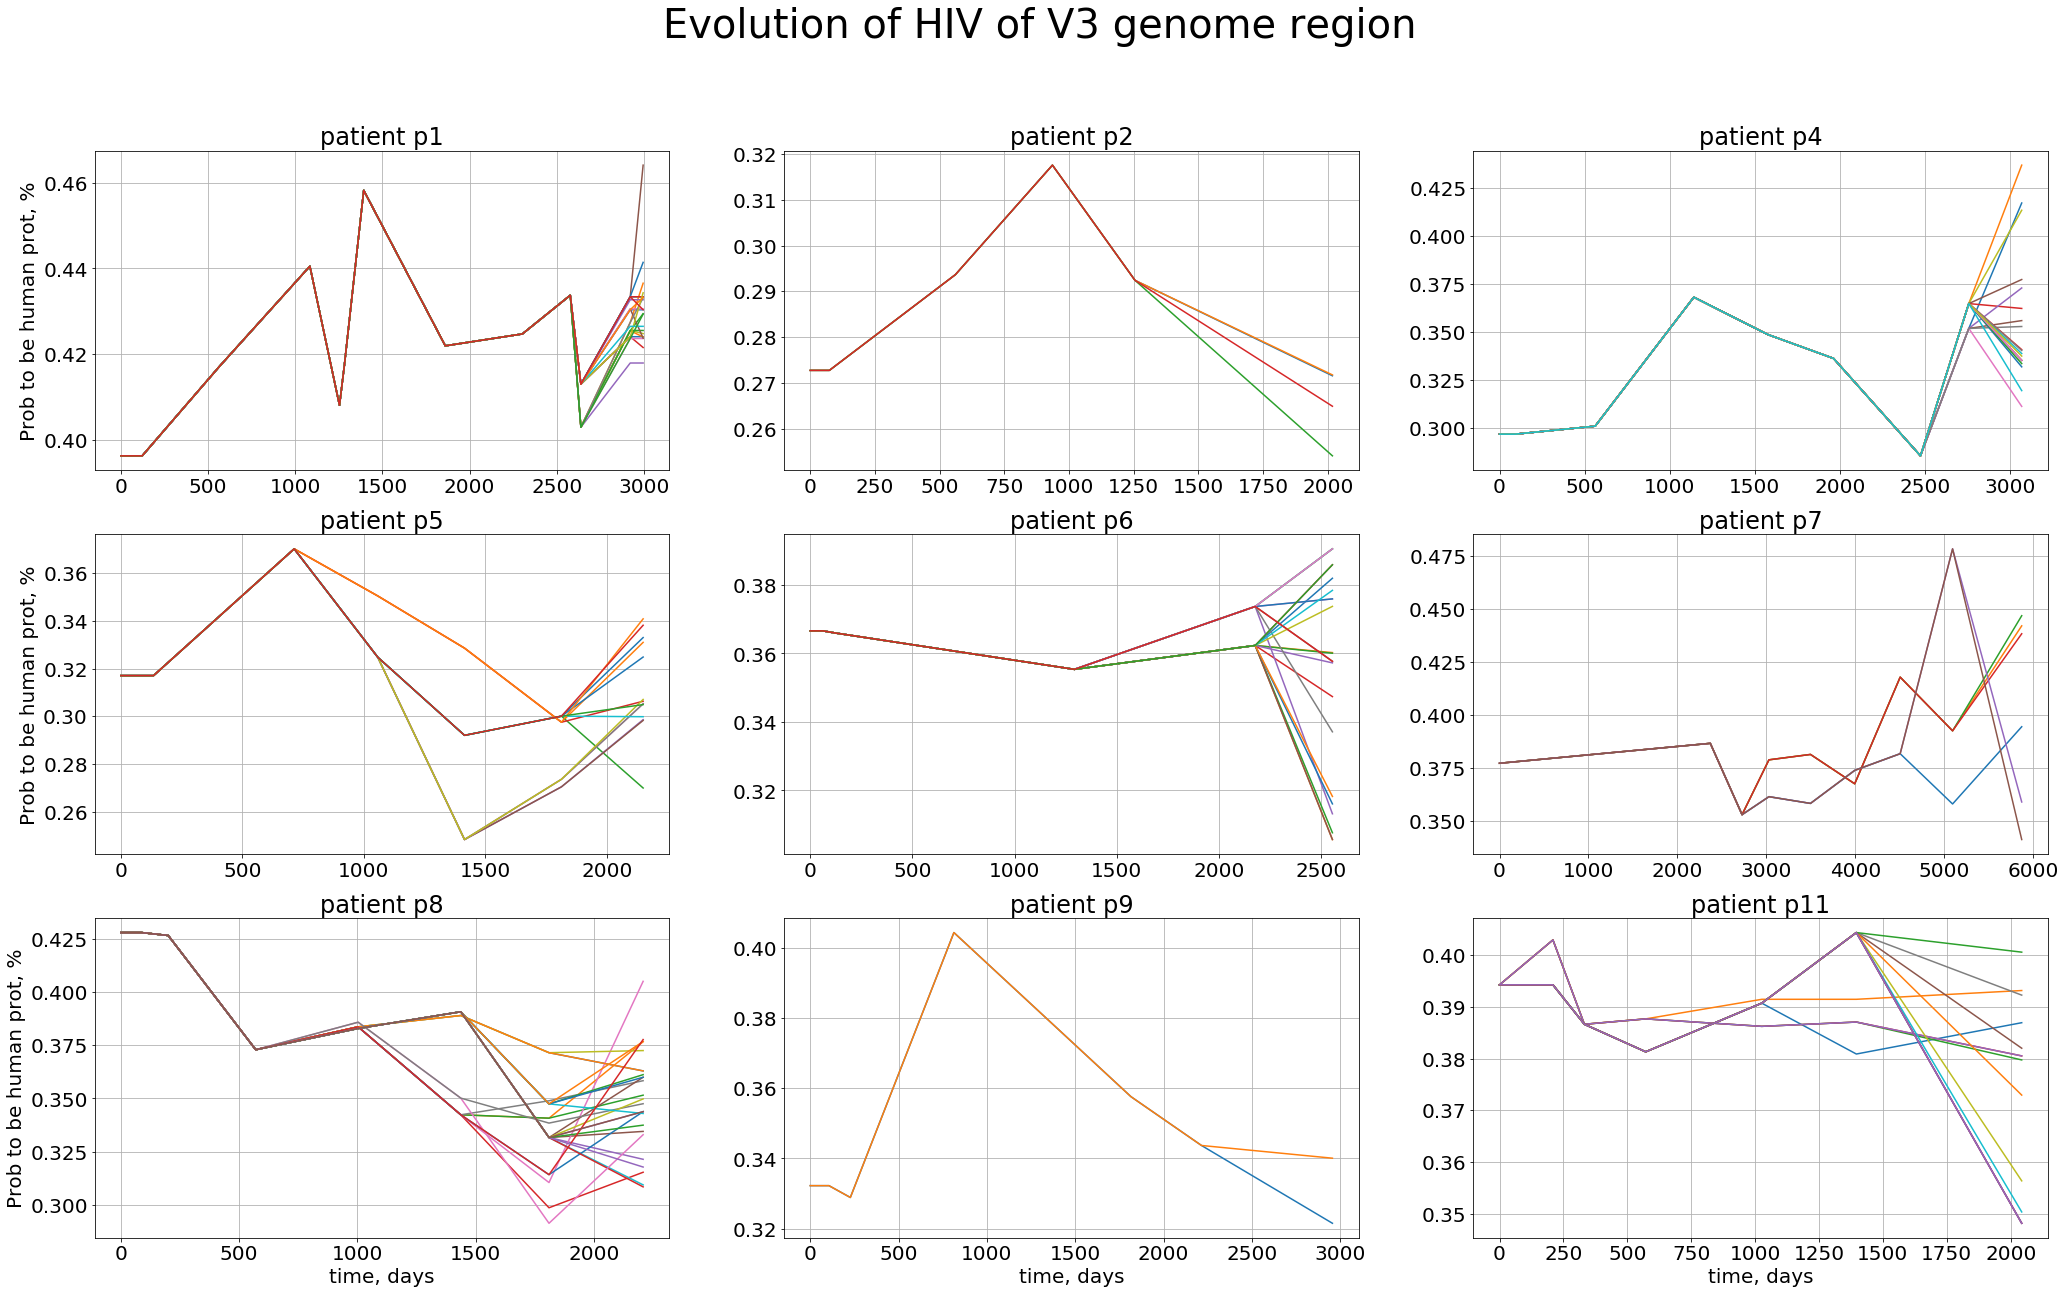

In [45]:
quant = quantitative_analyze.Quantitative([f'p{i}' for i in range(1, 12)])

quant.loading_classificator('saved_sklearn_models/imblearn.joblib')

quant.quantitative_analyzes('V3')

quant.plot_paths()